In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud
EN = spacy.load('en_core_web_sm')

In [2]:
data = pd.read_csv('data/Preprocessed_data.csv')
print(data.shape)
data.head()

(140879, 10)


post_corpus  \
0  using match attribute python objects array nt ...   
1  specifying mysql enum django model go specifyi...   
2  unicode vs utf8 confusion python django stumbl...   
3  cleanest fastest server setup django deploy me...   
4  always including user django template context ...   

                                    question_content  \
0  using match attribute python objects array nt ...   
1  specifying mysql enum django model go specifyi...   
2  unicode vs utf8 confusion python django stumbl...   
3  cleanest fastest server setup django deploy me...   
4  always including user django template context ...   

                                question_url  \
0    https://stackoverflow.com/questions/683   
1  https://stackoverflow.com/questions/21454   
2  https://stackoverflow.com/questions/22149   
3  https://stackoverflow.com/questions/26025   
4  https://stackoverflow.com/questions/41547   

                                           tags  overall_scores_norm  \
0                       python|arrays|iteration             0.012227   
1       python|mysql|django|django-models|enums             0.029648   
2                         python|django|unicode             0.007405   
3                  python|django|apache|hosting             0.008494   
4  python|django|authentication|session|cookies             0.015027   

   sentiment_polarity  sentiment_subjectivity  \
0            0.163567                0.568209   
1            0.035299                0.536159   
2            0.082857                0.403250   
3            0.205105                0.483688   
4            0.052020                0.628824   

                                 processed_title  \
0     using match attribute python objects array   
1             specifying mysql enum django model   
2        unicode vs utf8 confusion python django   
3           cleanest fastest server setup django   
4  always including user django template context   

                                      original_title  overall_scores  
0  Using 'in' to match an attribute of Python obj...              84  
1          Specifying a mySQL ENUM in a Django model             196  
2     Unicode vs UTF-8 confusion in Python / Django?              53  
3         Cleanest & Fastest server setup for Django              60  
4  Always including the user in the django templa...             102

In [3]:
# Make a dict having tag frequencies
data.tags = data.tags.apply(lambda x: x.split('|'))
tag_freq_dict = {}
for tags in data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

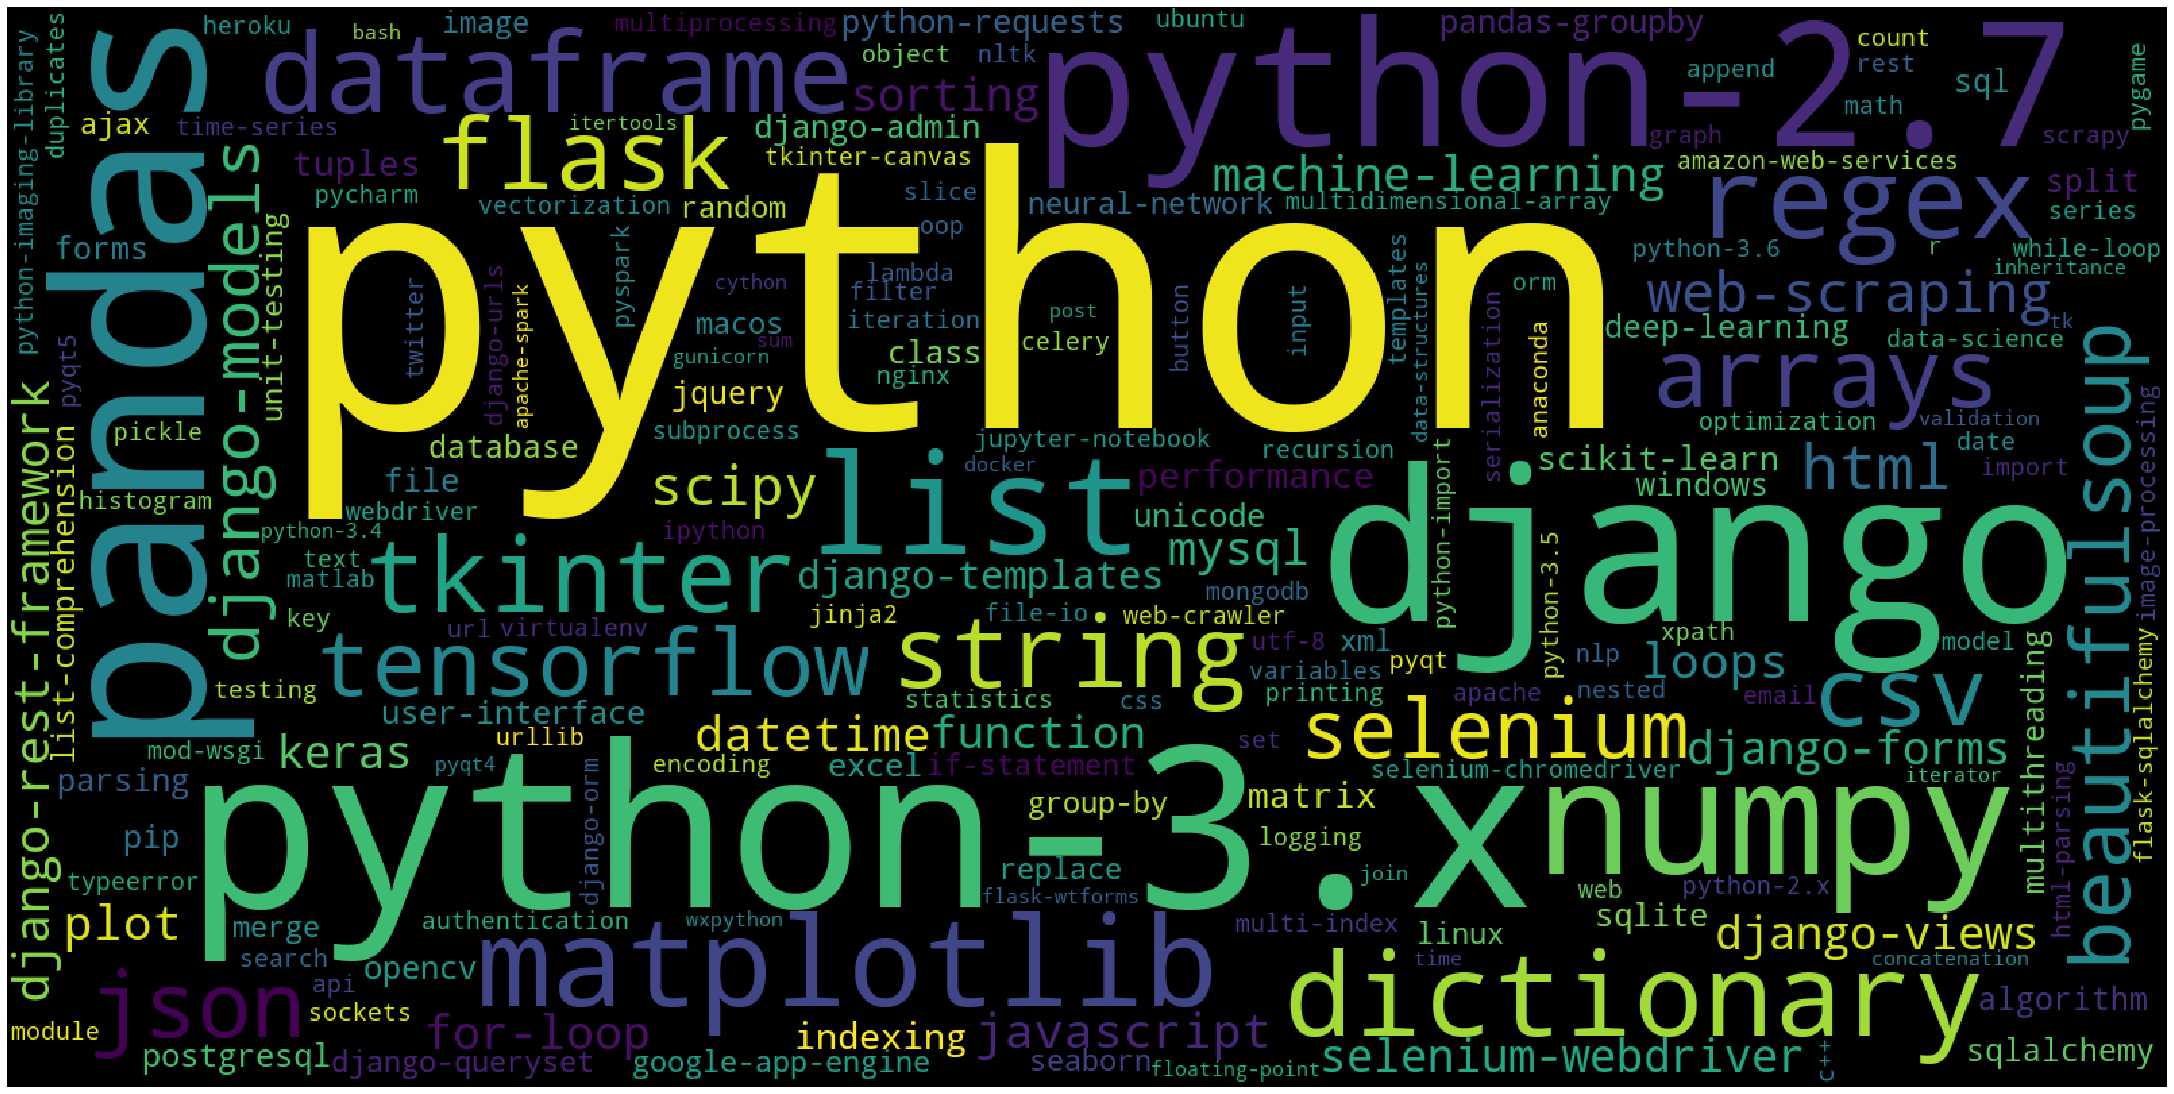

In [4]:
# Visualize all tags based on their frequencies using a WordCloud
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tag_freq_dict)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [5]:
# Get most common tags
tags_to_use = 500
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]
len(final_tags)

500

In [6]:
# Change tag data to only for final_tags
final_tag_data = []
for tags in data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
tags_encoded.shape

(140879, 500)

In [8]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Collect corpus for training word embeddings
documents = [_text.split() for _text in np.array(data.post_corpus)]  # I used the entire corpus for training, because it contains the entire conversation of related to a user's posts

In [13]:
data.post_corpus[0]

'using match attribute python objects array nt remember whether dreaming seem recall function allowed something like function thinking probably example get list contains value object attribute import operator ids mapoperatorattrgetterid bar'

In [21]:
# Train Word Embeddings and save
'''
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('SO_word2vec_embeddings.bin')
'''

'\nw2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, \n                                            window=W2V_WINDOW, \n                                            min_count=W2V_MIN_COUNT, \n                                            workers=8)\nw2v_model.build_vocab(documents)\nwords = w2v_model.wv.vocab.keys()\nvocab_size = len(words)\nprint("Vocab size", vocab_size)\n# Train Word Embeddings\nw2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)\nw2v_model.save(\'SO_word2vec_embeddings.bin\')\n'

In [22]:
# Load pre-trained embeddings
w2v_model = gensim.models.word2vec.Word2Vec.load('models/SO_word2vec_embeddings.bin')

In [23]:
# Testing Word Embeddings
print('Terms most similar to "django"')
print(w2v_model.wv.most_similar("django"))
print('-'*100)

print('Terms most similar to "api"')
print(w2v_model.wv.most_similar("api"))
print('-'*100)

print('Terms most similar to "gunicorn"')
print(w2v_model.wv.most_similar("gunicorn"))
print('-'*100)

print('Terms most similar to "server"')
print(w2v_model.wv.most_similar("server"))

Terms most similar to "django"
[('flask', 0.5827779173851013), ('project', 0.5168731212615967), ('mezzanine', 0.5122816562652588), ('wagtail', 0.5001770257949829), ('drf', 0.4827461242675781), ('framework', 0.48031285405158997), ('cms', 0.47275760769844055), ('admin', 0.467496395111084), ('database', 0.4659809470176697), ('app', 0.46219539642333984)]
----------------------------------------------------------------------------------------------------
Terms most similar to "api"
[('apis', 0.6121899485588074), ('webservice', 0.5226354598999023), ('service', 0.49891555309295654), ('framework', 0.4883273243904114), ('postman', 0.47500693798065186), ('webhook', 0.4574393630027771), ('rpc', 0.4385871887207031), ('oauth2', 0.41829735040664673), ('twilio', 0.4138619303703308), ('application', 0.4100519120693207)]
----------------------------------------------------------------------------------------------------
Terms most similar to "gunicorn"
[('uwsgi', 0.5529206991195679), ('nginx', 0.510335

In [25]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(data.processed_title), tags_encoded, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 112703
TEST size: 28176


In [26]:
# Tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

'''
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.post_corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# saving
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

Using TensorFlow backend.


"\ntokenizer = Tokenizer()\ntokenizer.fit_on_texts(data.post_corpus)\nword_index = tokenizer.word_index\nvocab_size = len(word_index)\nprint('Found %s unique tokens.' % len(word_index))\n\n# saving\nimport pickle\nwith open('tokenizer.pickle', 'wb') as handle:\n    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [27]:
# loading tokenizer
import pickle
with open('models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 444998 unique tokens.


In [28]:
# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (112703, 300)


In [29]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(444999, 300)


In [36]:
import keras.backend as K

# Custom loss function to handle multilabel classification task
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [37]:
'''
# Build Model
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units = 10000,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )  
model.add(Dropout(0.35))
model.add(Dense(units = 1150,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dropout(0.25))
model.add(Dense(units = 750,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dense(500, activation='sigmoid'))

model.summary()

model.compile(loss=multitask_loss,
              optimizer="adam")
              
# Train Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=15,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# Save model
model.save('models/Tag_predictor.h5')
'''

'\n# Build Model\nimport keras \n\nmodel = Sequential()\nmodel.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))\nmodel.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))\nmodel.add(Dense(units = 10000,\n                     kernel_initializer = \'glorot_uniform\',\n                     activation = \'relu\'\n                    )\n              )  \nmodel.add(Dropout(0.35))\nmodel.add(Dense(units = 1150,\n                     kernel_initializer = \'glorot_uniform\',\n                     activation = \'relu\'\n                    )\n              )\nmodel.add(Dropout(0.25))\nmodel.add(Dense(units = 750,\n                     kernel_initializer = \'glorot_uniform\',\n                     activation = \'relu\'\n                    )\n              )\nmodel.add(Dense(500, activation=\'sigmoid\'))\n\nmodel.summary()\n\nmodel.compile(loss=multitask_loss,\n              optimizer="adam")\n              \n# Train Model\nfrom

In [38]:
# Helper function to save the training history for plotting purposes

import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

In [ ]:
from keras.models import load_model
import keras.losses

keras.losses.multitask_loss = multitask_loss
model = load_model('models/Tag_predictor.h5')
history = loadHist('train_history.json')

28176/28176 [==============================] - ETA: 1: - ETA: 46s - ETA: 40 - ETA: 37 - ETA: 35 - ETA: 33 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 32s 1ms/step
LOSS: 5.44004239174942


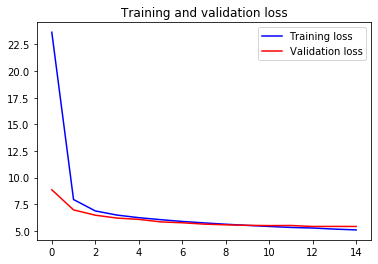

In [44]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("LOSS:",score)

loss = history['loss']
val_loss = history['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [45]:
# A wrapper function in order to predict the tags for any given input

def predict_tags(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    prediction = model.predict([x_test])[0]
    for i,value in enumerate(prediction):
        if value > 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [65]:
test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: selecting n1d array nd array numpy
----------------------------------------------------------------------------------------------------
Predicted: [('arrays', 'numpy', 'python')]
Ground Truth: [('numpy', 'python')]


Test Case: taking info file
----------------------------------------------------------------------------------------------------
Predicted: [('python',)]
Ground Truth: [('python', 'python-2.6', 'python-2.7')]


Test Case: python find txt continue causing fault
----------------------------------------------------------------------------------------------------
Predicted: [('python',)]
Ground Truth: [('python', 'python-3.x')]


Test Case: fabric rsync read error connection reset peer 104
----------------------------------------------------------------------------------------------------
Predicted: [('django', 'python')]
Ground Truth: [('django', 'python', 'windows')]


Test Case: fllter pandas dataframe multiple columns
--------------------------------------------